In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [3]:
data_dir = r"C:/Users/Anton/OneDrive/Desktop/КПІлабки/lab3 Габунія А.П. ФІ-51мн"

train_dir = os.path.join(data_dir, "seg_train", "seg_train")
val_dir   = os.path.join(data_dir, "seg_test",  "seg_test")


In [4]:
train_tf = transforms.Compose([
    transforms.Resize((64, 64)),      # required for ResNet
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [5]:
train_ds_full = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds_full   = datasets.ImageFolder(val_dir,   transform=val_tf)

print("Full train size:", len(train_ds_full))
print("Full val size:", len(val_ds_full))

# вибираємо підмножину (для швидкої ResNet навчалки)
train_size = min(4000, len(train_ds_full))
val_size   = min(1000, len(val_ds_full))

train_ds, _ = random_split(train_ds_full, [train_size, len(train_ds_full) - train_size])
val_ds,   _ = random_split(val_ds_full,   [val_size,   len(val_ds_full)   - val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2)

num_classes = len(train_ds_full.classes)
print("Classes:", train_ds_full.classes)
print("Train subset:", len(train_ds), "Val subset:", len(val_ds))



Full train size: 14034
Full val size: 3000
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train subset: 4000 Val subset: 1000


In [6]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace the classifier
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)


In [8]:
def train_model(model, train_loader, val_loader, epochs=5):
    train_hist = []
    val_hist = []
    val_acc_hist = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()

                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total

        train_hist.append(train_loss)
        val_hist.append(val_loss)
        val_acc_hist.append(val_acc)

        print(f"[{epoch+1}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc*100:.2f}%")

    return train_hist, val_hist, val_acc_hist


In [ ]:
train_loss_r, val_loss_r, val_acc_r = train_model(
    resnet, train_loader, val_loader, epochs=5
)


[1] train_loss=1.3016 | val_loss=0.9699 | val_acc=67.60%
[2] train_loss=0.8782 | val_loss=0.8169 | val_acc=72.30%
[3] train_loss=0.7631 | val_loss=0.7704 | val_acc=73.30%


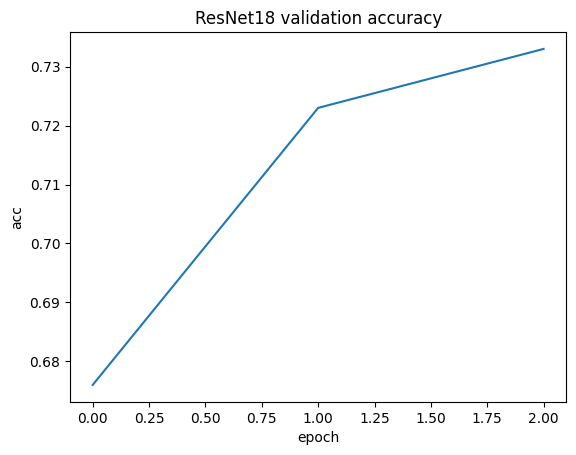

In [10]:
plt.plot(val_acc_r)
plt.title("ResNet18 validation accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()